In [490]:
import pickle
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [230]:
user_df = pickle.load(open('7_23/user_data.p','rb'))
transaction_df = pickle.load(open('7_23/transaction_data.p','rb'))
new_users = pickle.load(open('7_23/new_users.p','rb'))

### Time Series Analysis:

Analyze volume of venmo transactions grouped by different times. Analyzing transactions during different days of the week. The effect of COVID, etc. 

In [231]:
transaction_df['date_created_str'] = transaction_df['date_created'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [451]:
transaction_df['weekday'] = transaction_df['date_created_str'].apply(lambda x: x.weekday())
transaction_df['month'] = transaction_df['date_created_str'].apply(lambda x: x.month)
transaction_df['year'] = transaction_df['date_created_str'].apply(lambda x: x.year)
transaction_df['hour'] = transaction_df['date_created_str'].apply(lambda x: x.time().hour)

Text(0, 0.5, 'Percentage of Transactions')

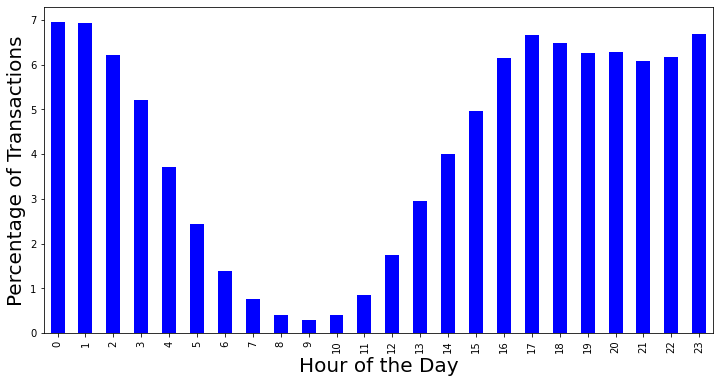

In [420]:
#When do people use venmo
plt.figure(figsize=(12,6))
(100*transaction_df.groupby('hour').size()/transaction_df.shape[0]).plot.bar(color='b')
plt.xlabel('Hour of the Day',fontsize = 20)
plt.ylabel('Percentage of Transactions',fontsize = 20)
#plt.title('Time of Day People Use Venmo')

In [452]:
100*(transaction_df.groupby('weekday').size())/transaction_df.shape[0] #When do people use venmo

weekday
0    14.034141
1    12.604184
2    12.518868
3    12.925760
4    14.766256
5    16.300488
6    16.850303
dtype: float64

In [453]:
day_dict = {0 : 'Monday',1 : 'Tuesday' ,2 : 'Wednesday',3 : 'Thursday',4: 'Friday',5 : 'Saturday',6: 'Sunday'}
def weekday(x):
    return day_dict[x]

In [454]:
transaction_df['weekday_str'] = transaction_df['weekday'].apply(weekday)

In [394]:
day_order = list(day_dict.values())
day_order
day_percent = (100*(transaction_df.groupby('weekday').size())/transaction_df.shape[0])

In [415]:
user_df.iloc[0]

username                                                     Mike-Sender
first_name                                                          Mike
last_name                                                         Sender
user_id                                              1350836974256128854
phone                                                               None
profile_picture_url    https://pics.venmo.com/9f06a2b5-5cf1-4a20-a15e...
is_active                                                           True
Name: 0, dtype: object

Text(0, 0.5, 'Percentage of Transactions')

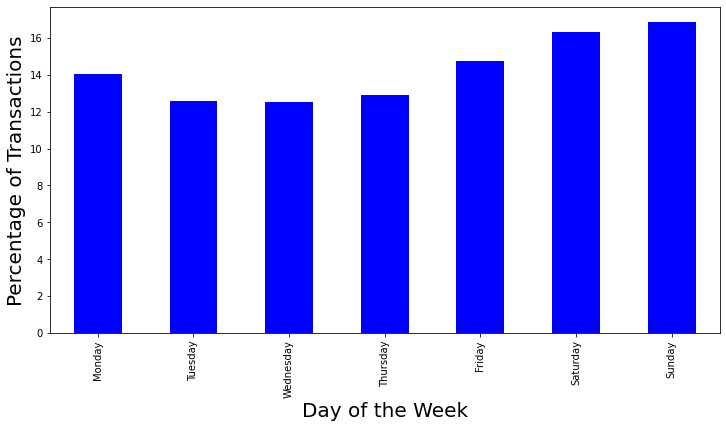

In [421]:
plt.figure(figsize=(12,6))
ax = day_percent.loc[day_order].plot.bar(color='b')
plt.xlabel('Day of the Week',fontsize = 20)
plt.ylabel('Percentage of Transactions', fontsize = 20)

In [92]:
#not gonna work without more data :(
#transaction_df.groupby(['year','month']).size() 

year  month
2014  12           5
2015  1            4
      2            8
      3            8
      4           22
               ...  
2020  3         9756
      4         6755
      5         8795
      6        11856
      7         8661
Length: 68, dtype: int64

### Transaction Type:

Analyze the type of transaction using NLP. Add a new column with a specific categorical variable of the type of transaction. 



In [234]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop = stopwords.words('english')
stop = stop + ['skin' , 'face' , 'light']

In [235]:
#Copy the note column to change and analyze while preserving initial note dota
transaction_df['note_analysis'] = transaction_df['note']

In [236]:
#Clean note_analysis column:
#Lower case
#Replace underscores with spaces
#Turn emojis into words
#Strip punctuation
#Remove stop words
#Run stemmer to simplify like words
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: x.lower())
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join(emoji.demojize(word) for word in text.split()))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: x.replace('_',' '))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: re.sub('[^\w\s]', '', x))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

In [146]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400, collocations=False)
# generate word cloud
wc.generate(' '.join(transaction_df['note_analysis']))

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

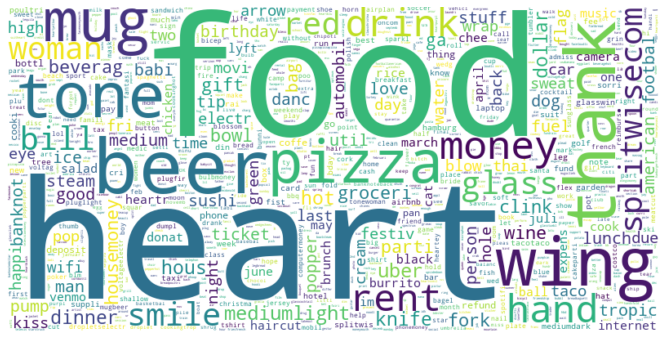

In [148]:
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [237]:
#print out most seen 
nested_words = [[word for word in note.split(' ')] for note in transaction_df['note_analysis']]

#figure out emojis...

In [238]:
words = [item for sublist in nested_words for item in sublist]

In [239]:
wordcount = {}
for word in words:
    if word not in wordcount.keys():
        wordcount[word] = 1
    else:
        wordcount[word] += 1
        

In [240]:
wordcount = {k : v for k,v in sorted(wordcount.items(), key=lambda item: item[1], reverse = True)}

In [52]:
emoji.emojize(':pizza:')

'🍕'

In [241]:
wordcount

{'food': 3685,
 'heart': 3618,
 'beer': 3214,
 'thank': 2762,
 'wing': 2675,
 'tone': 2355,
 'mug': 2098,
 'pizza': 2013,
 'money': 1826,
 'drink': 1666,
 'hand': 1650,
 'rent': 1556,
 'glass': 1555,
 'splitwisecom': 1462,
 'bill': 1452,
 'red': 1449,
 'smile': 1417,
 'woman': 1371,
 'mediumlight': 1343,
 'uber': 1339,
 'hous': 1257,
 'hot': 1250,
 'dinner': 1197,
 'dollar': 1148,
 'knife': 1140,
 'groceri': 1068,
 'gift': 1056,
 'fork': 1056,
 'bowl': 1038,
 'parti': 1035,
 'wine': 1033,
 'beverag': 1012,
 'housemoney': 974,
 'clink': 969,
 'get': 942,
 'ga': 874,
 '2': 859,
 'birthday': 829,
 'ice': 820,
 'ticket': 818,
 'medium': 806,
 'bag': 803,
 'stuff': 789,
 'tropic': 787,
 'love': 776,
 'dog': 770,
 '': 761,
 'steam': 757,
 'man': 743,
 'tip': 730,
 'danc': 729,
 'lunch': 724,
 'util': 717,
 'fuel': 716,
 'popper': 709,
 'babi': 695,
 'footbal': 693,
 '3': 684,
 'sushi': 683,
 'pump': 672,
 'banknot': 667,
 'person': 657,
 'good': 653,
 'american': 639,
 'fri': 607,
 'pop': 60

In [476]:
def categorize(note):
    if (re.search('uber|lyft|taxi|cab|automobil',note) != None):
        return 'taxi'
    #Does the word rent or a month appear in the note
    if (re.search(' rent$|^rent$|^rent |groceri|wifi|bill|housemoney|internet|electr',note) != None):
        return 'household'
    if (re.search('airbnb|hotel|airplan|tropic|fuel|toll|beach|ski',note) != None): 
        return 'vacation'        
    if (re.search(' food$|^food$|^food |pizza|thai|taco|brunch|dinner|sushi|lunch|burger|chipotle|coffe|sandwich|breakfast|bread|bagel',note)!= None):
        return 'dining'
    if (re.search('parti|festiv|beer|drink|alcohol|mug|wine|bar|ticket|clink|danc|glasswin|cakeparti',note) != None):
        return 'entertainment'
    return 'unknown'

In [477]:
transaction_df.loc[:,'category'] = transaction_df['note_analysis'].apply(lambda x: categorize(x))

In [478]:
1-(sum(transaction_df['category'] == 'unknown')/transaction_df.shape[0])

0.25411814462909355

In [493]:
categories = transaction_df[transaction_df['category'] != 'unknown']

In [496]:

category_colors = {'dining': 'b', 'entertainment': 'r', 'household': 'g','taxi': 'm','vacation': 'c'}

Text(0.5, 0, '')

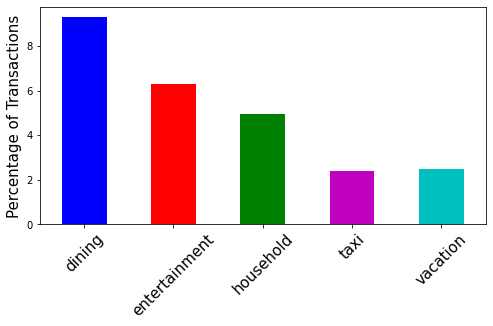

In [508]:
plt.figure(figsize = (8,4))
(100*categories.groupby('category').size()/transaction_df.shape[0]).plot.bar(color=list(category_colors.values()))
plt.ylabel('Percentage of Transactions',fontsize = 15)
plt.xticks(fontsize = 15, rotation = 45)
plt.xlabel(None)

Text(0, 0.5, 'Percentage of Transactions')

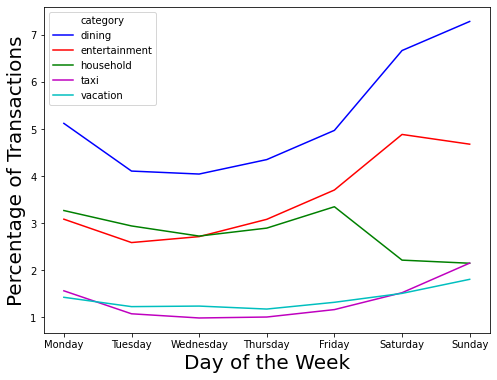

In [502]:
plt.figure(figsize = (8,6))
sns.lineplot(x= 'weekday',y = 0,data = days, hue = 'category', palette = category_colors) #think about normalizing
plt.xlabel('Day of the Week',fontsize = 20)
plt.xticks(range(7),day_order)
plt.ylabel('Percentage of Transactions', fontsize = 20)

In [481]:
data = data.reset_index()

In [482]:
data = categories.groupby(['category','hour']).size().to_frame().reset_index()

In [483]:
days = categories.groupby(['category','weekday']).size().to_frame().reset_index()

In [484]:
days[0] = 100*(days[0]/categories.shape[0])

### Network Analysis 

Analyze network to rank people with similar spending. Personalizaed page rank to 

-Uber, lyft

In [93]:
import networkx as nx

In [619]:
G_venmo = nx.MultiGraph()
G_venmo.add_nodes_from(user_df['user_id'])
G_venmo.add_edges_from(list(zip(transaction_df['actor_id'], transaction_df['target_id'])))
print(G_venmo.size())

137137


In [633]:
def user_rank(user, G, num_friends = 5):
    personalization = {user : 1}
    page_rank_users = nx.pagerank_scipy(G, personalization = personalization)  
    page_rank_users = {u : v for u,v in sorted(page_rank_users.items(), key=lambda item: item[1], reverse = True)}
    friends = list(page_rank_users)[0:num_friends+1]
    return friends

In [646]:
me = user_df['user_id'][0]
my_close_friends = user_rank(me, G_venmo,6)
near_me = user_rank(me, G_venmo,400)

In [647]:
close_network = set(my_close_friends) | set(near_me)
G_close = G_venmo.subgraph(close_network)


In [648]:
pos = nx.spring_layout(G_close)

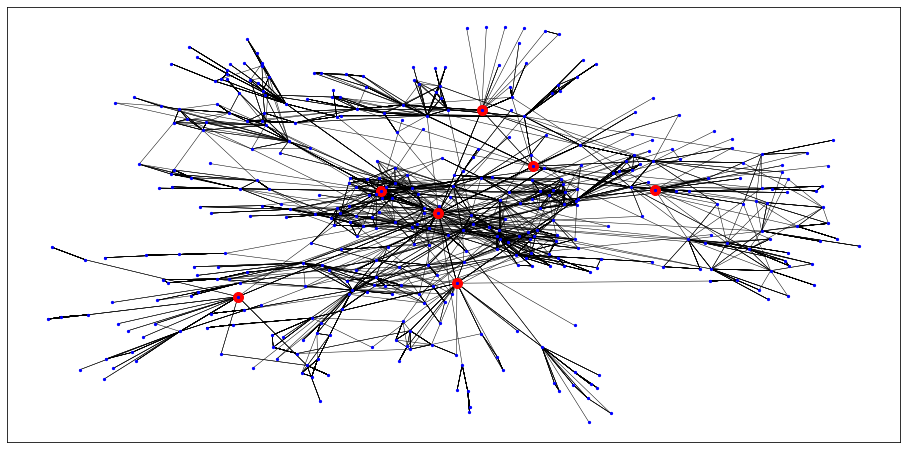

In [684]:

plt.figure(figsize=(16,8), frameon= False)
nx.draw_networkx_nodes(G_close, pos, nodelist = my_close_friends, node_color="r",node_size=100, axis = 'off')
nx.draw_networkx_nodes(G_close, pos, nodelist = near_me, node_color="b",node_size=5, axis= 'off' )
nx.draw_networkx_edges(G_close, pos, edgelist = G_close.edges, width = .5, axis = 'off')


In [601]:
user_df[user_df['user_id'].apply(lambda x: x in my_friends)]['first_name']

1        Rachel
3          Eric
7          Anna
11         Josh
56          Ian
3282    Charles
Name: first_name, dtype: object

In [352]:
uber_df = transaction_df[transaction_df['note_analysis'].str.contains('uber')]

In [353]:
lyft_df = transaction_df[transaction_df['note_analysis'].str.contains('lyft')]

In [354]:
uber_users = set(list(uber_df['actor_id']) + list(uber_df['target_id']))

In [355]:
lyft_users = set(list(lyft_df['actor_id']) + list(lyft_df['target_id']))

In [357]:
prob = 1/len(uber_users)
uber_personalization = {user : prob for user in uber_users}

ranked_uber_network = nx.pagerank_scipy(G_venmo, personalization = uber_personalization)
ranked_uber_network = {u : v for u,v in sorted(ranked_uber_network.items(), key=lambda item: item[1], reverse = True)}
top_uber_users = list(ranked_uber_network)[:4000]

In [358]:
prob = 1/len(lyft_users)
lyft_personalization = {user : prob for user in lyft_users}

ranked_lyft_network = nx.pagerank_scipy(G_venmo, personalization = lyft_personalization)
ranked_lyft_network = {u : v for u,v in sorted(ranked_lyft_network.items(), key=lambda item: item[1], reverse = True)}
top_lyft_users = list(ranked_lyft_network)[:4000]

In [359]:
len(set(top_uber_users) - set(top_lyft_users))

2231

In [360]:
G_ubers_lyfts = G_venmo.copy()

In [361]:
for node in (set(G_venmo.nodes) - (set(top_uber_users) | set(top_lyft_users))):
    G_ubers_lyfts.remove_node(node)
    

In [362]:
uber_lyft_users = set(top_uber_users) & set(top_lyft_users)

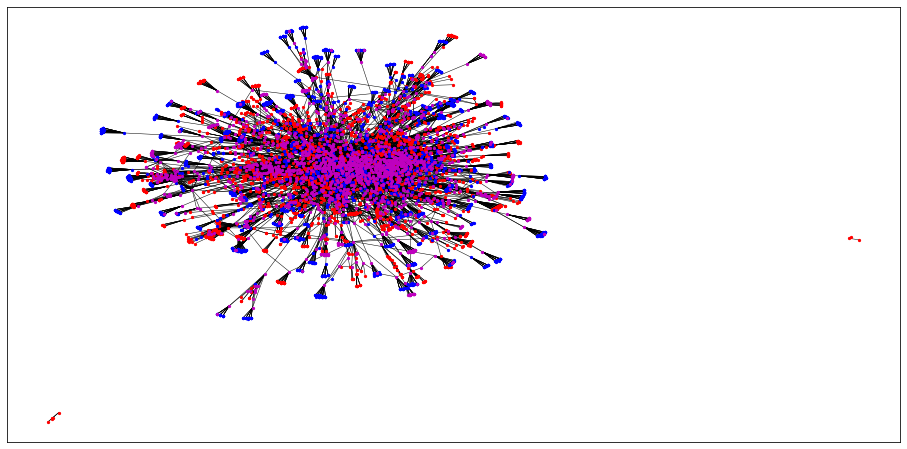

In [363]:
pos = nx.spring_layout(G_venmo)
plt.figure(figsize=(16,8))
nx.draw_networkx_nodes(G_venmo, pos, nodelist = set(top_uber_users)-uber_lyft_users, node_color="r",node_size=5)
nx.draw_networkx_nodes(G_venmo, pos, nodelist = set(top_lyft_users)-uber_lyft_users, node_color="b",node_size=5)
nx.draw_networkx_nodes(G_venmo, pos, nodelist = uber_lyft_users, node_color="m",node_size=5)
nx.draw_networkx_edges(G_venmo, pos, edgelist = G_ubers_lyfts.edges, width = .5)

In [351]:
#slice whole dataframe by top users



category
taxi    1396
dtype: int64

2477